# Dataset | Problem

Context:

Attribute Information:

Data vocabulary:

Acknowledgements:
(Confidential Source) - Use only for educational purposes
If you use this dataset in your research, please credit the author.

In [ ]:
# df[df.species =="Gentoo"].groupby("sex").describe().T
# df.loc[336, "sex"] = "MALE"
# sns.catplot(x='species', data=df, kind='count',col='sex')
# fig = px.scatter_3d(df, 
#                     x='culmen_length_mm',
#                     y='flipper_length_mm',
#                     z='culmen_depth_mm',
#                     color='species')
# fig.show();


# knn_conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_test_pred))
# knn_conf_matrix.columns = pd.MultiIndex.from_product([knn_conf_matrix.columns, ['for knn']])

# knn = get_classification_report(y_test, y_test_pred)
# knn.columns = pd.MultiIndex.from_product([knn.columns, ['for knn']])
# print('confusion_matrix:\n\n', knn_conf_matrix, '\n\n')
# print('classification_report:\n\n', knn)

# Import Libraries

In [1]:
# 1-Import Libraies

#!pip install lightgbm
#!pip install catboost

import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
%matplotlib notebook
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

#Model Selection
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import KFold, cross_val_predict

#Feature Selection
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif, f_regression, mutual_info_regression

#Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.linear_model import LogisticRegression

from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

from sklearn.svm import SVC
from sklearn.svm import SVR

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import ExtraTreesRegressor

from xgboost import XGBClassifier
from xgboost import plot_importance

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.neural_network import MLPRegressor

#Scaling
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


#Metrics
from sklearn import metrics
from sklearn.metrics import roc_auc_score, auc, roc_curve, precision_recall_curve
from sklearn.metrics import accuracy_score, recall_score, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 


#Importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

#Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

#Figure&Display options
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('max_colwidth',200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Useful Functions

In [2]:
## Useful Functions

###############################################################################


def first_looking(column):
    print("column name    : ", column) 
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[column].isnull().sum()/df.shape[0]*100, 2))
    print("num_of_nulls   : ", df[column].isnull().sum())
    print("num_of_uniques : ", df[column].nunique())
    print("value_counts : ", df[column].value_counts(dropna = False).head())
    
# for i in df.columns:
#     first_looking(i)

###############################################################################


def missing (df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

###############################################################################

def perc_nans(serial):  # Ex:perc_nans(df['kW'])
    # display percentage of nans in a Series
    return serial.isnull().sum()/serial.shape[0]*100

def perc_nans_byLimitless(df):
    return df.isnull().sum()/df.shape[0]*100

def perc_nans_byLimit(df, limit):
    missing = df.isnull().sum()*100/df.shape[0]
    return missing.loc[lambda x : x >= limit]

# perc_nans_byLimit(df, 90)

###############################################################################

def fill_most(df, group_col, col_name):
    '''Fills the missing values with the most existing value (mode) in the relevant column according to single-stage grouping'''
    for group in list(df[group_col].unique()):
        cond = df[group_col]==group
        mode = list(df[cond][col_name].mode())
        if mode != []:
            df.loc[cond, col_name] = df.loc[cond, col_name].fillna(df[cond][col_name].mode()[0])
        else:
            df.loc[cond, col_name] = df.loc[cond, col_name].fillna(df[col_name].mode()[0])
    print("Number of NaN : ",df[col_name].isnull().sum())
    print("------------------")
    print(df[col_name].value_counts(dropna=False))
    
###############################################################################

def fill_prop(df, group_col, col_name):
    for group in list(df[group_col].unique()):
        cond = df[group_col]==group
        df.loc[cond, col_name] = df.loc[cond, col_name].fillna(method="ffill").fillna(method="bfill")
    df[col_name] = df[col_name].fillna(method="ffill").fillna(method="bfill")
    print("Number of NaN : ",df[col_name].isnull().sum())
    print("------------------")
    print(df[col_name].value_counts(dropna=False))
    
###############################################################################

def fill(df, group_col1, group_col2, col_name, method): # method can be "mode" or "median" or "ffill"
    if method == "mode":
        for group1 in list(df[group_col1].unique()):
            for group2 in list(df[group_col2].unique()):
                cond1 = df[group_col1]==group1
                cond2 = (df[group_col1]==group1) & (df[group_col2]==group2)
                mode1 = list(df[cond1][col_name].mode())
                mode2 = list(df[cond2][col_name].mode())
                if mode2 != []:
                    df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[cond2][col_name].mode()[0])
                elif mode1 != []:
                    df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[cond1][col_name].mode()[0])
                else:
                    df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[col_name].mode()[0])
                
    elif method == "median":
        for group1 in list(df[group_col1].unique()):
            for group2 in list(df[group_col2].unique()):
                cond1 = df[group_col1]==group1
                cond2 = (df[group_col1]==group1) & (df[group_col2]==group2)
                df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[cond2][col_name].median()).fillna(df[cond1][col_name].median()).fillna(df[col_name].median())
                
    elif method == "ffill":           
        for group1 in list(df[group_col1].unique()):
            for group2 in list(df[group_col2].unique()):
                cond2 = (df[group_col1]==group1) & (df[group_col2]==group2)
                df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(method="ffill").fillna(method="bfill")
                
        for group1 in list(df[group_col1].unique()):
            cond1 = df[group_col1]==group1
            df.loc[cond1, col_name] = df.loc[cond1, col_name].fillna(method="ffill").fillna(method="bfill")            
           
        df[col_name] = df[col_name].fillna(method="ffill").fillna(method="bfill")
    
    print("Number of NaN : ",df[col_name].isnull().sum())
    print("------------------")
    print(df[col_name].value_counts(dropna=False))
    
###############################################################################

def model_validation(y_train, y_train_pred, y_test, y_test_pred, model_name):
    
    scores =  {f"{model_name}_train": {"R2" : r2_score(y_train, y_train_pred),
    "rmse" : np.sqrt(mean_squared_error(y_train, y_train_pred)),
    "mse" : mean_squared_error(y_train, y_train_pred), 
    "mae" : mean_absolute_error(y_train, y_train_pred)},
    
    f"{model_name}_test": {"R2" : r2_score(y_test, y_test_pred),
    "rmse" : np.sqrt(mean_squared_error(y_test, y_test_pred)),
    "mse" : mean_squared_error(y_test, y_test_pred),
    "mae" : mean_absolute_error(y_test, y_test_pred)}}
     
    return pd.DataFrame(scores)

# lm = model_validation(y_train, y_train_pred, y_test, y_test_pred, 'lm')

# pd.concat([lm, rs, rcvs, lss, lcvs, es, ecvs], axis = 1)

###############################################################################

def get_classification_report(y_test, y_test_pred):
    from sklearn import metrics
    report = metrics.classification_report(y_test, y_test_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    #df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=False)
    return df_classification_report

###############################################################################

def shape_control():
    print('df.shape:', df.shape)
    print('X.shape:', X.shape)
    print('y.shape:', y.shape)
    print('X_train.shape:', X_train.shape)
    print('y_train.shape:', y_train.shape)
    print('X_test.shape:', X_test.shape)
    print('y_test.shape:', y_test.shape)
    print('y_test_pred.shape:', y_test_pred.shape)
    
###############################################################################
    
def get_report(model_name):
    y_train_pred = model_name.predict(X_train_scaled)
    y_train_pred_proba = model_name.predict_proba(X_train_scaled) 
    y_test_pred = model_name.predict(X_test_scaled)
    y_test_pred_proba = model_name.predict_proba(X_test_scaled)
    print("Train:")
    print('rmse:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
    print('accuracy:', accuracy_score(y_train, y_train_pred))
    print('roc_auc_score:',roc_auc_score(y_train, y_train_pred_proba[:,1]))
    precision, recall, _ = precision_recall_curve(y_train, y_train_pred_proba[:,1])
    print('roc_auc_recall_precision_score:',auc(recall, precision),'\n')
    print('confusion_matrix:\n\n', confusion_matrix(y_train, y_train_pred), '\n')
    print('classification_report:\n\n', get_classification_report(y_train, y_train_pred),'\n')
    print()
    print("Test:")
    print('rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred))) 
    print('accuracy:', accuracy_score(y_test, y_test_pred))
    print('roc_auc_score:',roc_auc_score(y_test, y_test_pred_proba[:,1]))
    precision, recall, _ = precision_recall_curve(y_test, y_test_pred_proba[:,1])
    print('roc_auc_recall_precision_score:',auc(recall, precision),'\n')
    print('confusion_matrix:\n\n', confusion_matrix(y_test, y_test_pred), '\n')
    print('classification_report:\n\n', get_classification_report(y_test, y_test_pred))

def train_control_table(model_name):
    y_train_pred = model_name.predict(X_train_scaled)
    y_train_pred = pd.DataFrame(y_train_pred)
    y_train_pred.rename(columns = {0: 'y_train_pred'}, inplace = True)
    return pd.concat([X_train, y_train, y_train_pred.set_index(y_train.index)], axis=1)

def test_control_table(model_name):
    y_test_pred = model_name.predict(X_test_scaled)
    y_test_pred = pd.DataFrame(y_test_pred)
    y_test_pred.rename(columns = {0: 'y_test_pred'}, inplace = True)
    return pd.concat([X_test, y_test, y_test_pred.set_index(y_test.index)], axis=1)

# Load | Read Data

In [4]:
# 2-Load|Read Data
csv_path = "water_potability.csv"
df0 = pd.read_csv(csv_path)
df = df0.copy() 
# drop_columns = "id"
# df.head()
# df.shape
# df.columns= df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')
# df.nunique()
# df.info()
# df.shape
# df.isnull().sum()
# missing(df)
# df.drop(drop_columns, axis=1, inplace=True)
# df.shape
# df.describe().T
# df.columns

FileNotFoundError: [Errno 2] No such file or directory: 'water_potability.csv'

# Exploratory Data Analysis and Visualization

## Features | Target

In [6]:
# 3-Target Examination
target = "target"

df.duplicated(subset=None, keep='first').sum()
df.drop_duplicates(keep = 'first', inplace = True)

# df = df.dropna()

X_columns = df.drop(target, axis=1).columns
X_categorical = df.drop(target, axis=1).select_dtypes('object')
X_numerical = df.drop(target, axis=1).select_dtypes('number').astype('float64')

# df[target].value_counts()
# X_columns
# X_numerical.columns
# X_categorical.columns
# X_numerical.columns.values

## Numerical Features

In [7]:
# # 5-Exploratory Data Analysis and Visualization with Seaborn

# sns.pairplot(df, hue=target);
# sns.clustermap(df.corr(), annot=True);
# sns.heatmap(df.corr(), annot=True);

###############################################################################

# for i in range(len(columns)):
#     plt.figure()
#     sns.lineplot(x=target, y=columns[i], data=df);

# for i in range(len(columns)):
#     plt.figure()
#     sns.swarmplot(x=target, y=columns[i], data=df);

# for i in range(len(columns)):
#     plt.figure()
#     sns.residplot(x=target, y=columns[i], data=df);

# for i in range(len(columns)):
#     plt.figure()
#     sns.barplot(x=target, y=columns[i], data=df);

# for i in range(len(columns)):
#     plt.figure()
#     sns.kdeplot(x=target, y=columns[i], data=df);

# for i in range(len(columns)):
#     plt.figure()
#     sns.boxenplot(x=target, y=columns[i], data=df);

# for i in range(len(columns)):
#     plt.figure()
#     sns.stripplot(x=target, y=columns[i], data=df);

# for i in range(len(columns)):
#     plt.figure()
#     sns.histplot(x=target, y=columns[i], data=df);

# for i in range(len(columns)):
#     plt.figure()
#     sns.jointplot(x=target, y=columns[i], data=df);

# for i in range(len(columns)):
#     plt.figure()
#     sns.relplot(x=target, y=columns[i], data=df);

# for i in range(len(columns)):
#     plt.figure()
#     sns.violinplot(x=target, y=columns[i], data=df);

# for i in range(len(columns)):
#     plt.figure()
#     sns.boxplot(x=target, y=columns[i], data=df);

# for i in range(len(columns)):
#     plt.figure()
#     sns.catplot(x=target, y=columns[i], data=df);

# for i in range(len(columns)):
#     plt.figure()
#     sns.displot(x=target, y=columns[i], data=df);

# for i in range(len(columns)):
#     plt.figure()
#     sns.lmplot(x=target, y=columns[i], data=df);

# for i in range(len(columns)):
#     plt.figure()
#     sns.scatterplot(x=target, y=columns[i], data=df);

# for i in range(len(columns)):
#     plt.figure()
#     sns.countplot(x=columns[i], data=df);

###############################################################################

# index = 0
# plt.figure(figsize=(20,20))
# for feature in X_numerical.columns:
#     if feature != target:
#         index += 1
#         plt.subplot(4,4,index)
#         sns.boxplot(x=target,y=feature,data=df);

###############################################################################

# matrix = np.triu(X_numerical.corr())
# fig, ax = plt.subplots(figsize=(14,10)) 
# sns.heatmap (X_numerical.corr(), annot=True, 
#              fmt= '.2f', vmin=-1, vmax=1, center=0, 
#              cmap='coolwarm',mask=matrix, ax=ax);
 
###############################################################################
    
# X_numerical_= X_numerical
# matrix = np.triu(X_numerical_.corr())
# fig, ax = plt.subplots(figsize=(14,10)) 
# sns.heatmap (X_numerical_.corr(), annot=True, 
#              fmt= '.2f', vmin=-1, vmax=1, center=0, 
#              cmap='coolwarm',mask=matrix, ax=ax);

###############################################################################

# # 6-Exploratory Data Analysis and Visualization with Plotly
# X_numerical.iplot(kind='hist');
# X_numerical.iplot(kind='histogram', subplots=True, bins=50);

###############################################################################

# # 7-Exploratory Data Analysis and Visualization with Axes3D 
# from mpl_toolkits.mplot3d import Axes3D 
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(df[X.columns[0]],df[X.columns[1]],df[target],c=df[target]);
# #"3d matplotlib scatter plot" https://matplotlib.org/3.1.1/gallery/mplot3d/scatter3d.html

###############################################################################

# # 8-Exploratory Data Analysis and Visualization with Plotly3D
# #!pip install plotly
# # https://plotly.com/python/3d-scatter-plots/
# import plotly.express as px
# fig = px.scatter_3d(df, x=X.columns[0], y=X.columns[1], z=target,
#               color=target)
# fig.show();

# fig = px.scatter_3d(df, 
#                     x='age',
#                     y='avg_glucose_level',
#                     z='bmi',
#                     color='stroke')
# fig.show();

## Skewness Control

In [8]:
# 9-Skewness Control
skew_limit = 0.75 
# This is our threshold-limit to evaluate skewness. 
# Overall below abs(1) seems acceptable for the linear models. 
skew_vals = X_numerical.skew()
skew_cols= skew_vals[abs(skew_vals)> skew_limit].sort_values(ascending=False)

# skew_cols
# X_numerical[skew_cols.index].iplot(kind='hist');
# X_numerical[skew_cols.index].iplot(kind='histogram',subplots=True,bins=50);

# Model Selection

## Train | Test Split & Scaling

In [258]:
# 10-Train|Test Split, Dummy 

# # Before dummy: 
# make_dtype_object = df[['categorical1','categorical2']].astype('object')

X_columns_ = df.drop(target, axis=1).columns
X_categorical_ = df.drop(target, axis=1).select_dtypes('object')
X_numerical_ = df.drop(target, axis=1).select_dtypes('number').astype('float64')

###############################################################################

if (df.dtypes==object).any():
    dummied = pd.get_dummies(X_categorical_, drop_first=True)
    X = pd.concat([X_numerical_, dummied[dummied.columns]], axis=1)
    
else:
    X = df.drop(target, axis=1).astype('float64')

y = df[target]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.30, 
                                                    random_state=42)

###############################################################################

# 11-MinMax Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# # 11-Standart Scaling
# from sklearn.preprocessing import StandartScaler
# scaler = StandartScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

###############################################################################

## Implement Logistic Regression and Evaluate¶

In [11]:
## Modelling - Decision Tree Classifier

###############################################################################

# # Simple Classifier
# from sklearn.tree import DecisionTreeClassifier
# simple_model = DecisionTreeClassifier(random_state=42)
# simple_model.fit(X_train, y_train)
# y_test_pred = simple_model.predict(X_test)

# model_name = simple_model
# report_model(model_name)
# #plt.figure(figsize=(8,6),dpi=150)
# plot_confusion_matrix(model_name, X_test, y_test_pred)

###############################################################################

# from yellowbrick.classifier import ClassPredictionError

# visualizer = ClassPredictionError(model_name)

# # Fit the training data to the visualizer
# visualizer.fit(X_train, y_train)

# # Evaluate the model on the test data
# visualizer.score(X_test, y_test_pred)

# # Draw visualization
# visualizer.poof();

# print(confusion_matrix(y_test, y_test_pred))
# print(classification_report(y_test, y_test_pred))

###############################################################################

# ## Cross Validation 
# from sklearn.model_selection import cross_val_score, cross_validate
# from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
# from sklearn.metrics import make_scorer

# cv_model = DecisionTreeClassifier(max_depth=None, random_state=42)
# scores = cross_validate(cv_model, X_train, y_train, scoring = ["accuracy", "precision_macro", "recall_macro", "f1_macro"], cv = 10)
# df_scores = pd.DataFrame(scores, index = range(1, 11))
# df_scores

# df_scores.mean()[2:]

###############################################################################

# ## Feature importances
# model_name = simple_model
# model_name.feature_importances_
# df_fi = pd.DataFrame(index=X.columns, data = model_name.feature_importances_, 
#                       columns = ["Feature Importance"]).sort_values("Feature Importance")
# df_fi.sort_values(by="Feature Importance", ascending=False).T

# # sns.barplot(data = df_fi, 
# #             x = df_fi.index, 
# #             y = 'Feature Importance', 
# #             order=df_fi.sort_values('Feature Importance', ascending=False).reset_index()['index'])
# # plt.xticks(rotation = 90)
# # plt.tight_layout()
# # plt.show();

In [407]:
# Simple Classifier
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42)
simple_model = model.fit(X_train_scaled, y_train)
y_test_pred = model.predict(X_test_scaled)

model =simple_model
get_report(model)

Train:
rmse: 0.0
accuracy: 1.0
roc_auc_score: 1.0
roc_auc_recall_precision_score: 1.0 

confusion_matrix:

 [[ 96   0]
 [  0 115]] 

classification_report:

               precision  recall  f1-score  support
0                 1.000   1.000     1.000   96.000
1                 1.000   1.000     1.000  115.000
accuracy          1.000   1.000     1.000    1.000
macro avg         1.000   1.000     1.000  211.000
weighted avg      1.000   1.000     1.000  211.000 


Test:
rmse: 0.4193139346887673
accuracy: 0.8241758241758241
roc_auc_score: 0.8282312925170068
roc_auc_recall_precision_score: 0.8900551275966558 

confusion_matrix:

 [[37  5]
 [11 38]] 

classification_report:

               precision  recall  f1-score  support
0                 0.771   0.881     0.822   42.000
1                 0.884   0.776     0.826   49.000
accuracy          0.824   0.824     0.824    0.824
macro avg         0.827   0.828     0.824   91.000
weighted avg      0.832   0.824     0.824   91.000


<IPython.core.display.Javascript object>


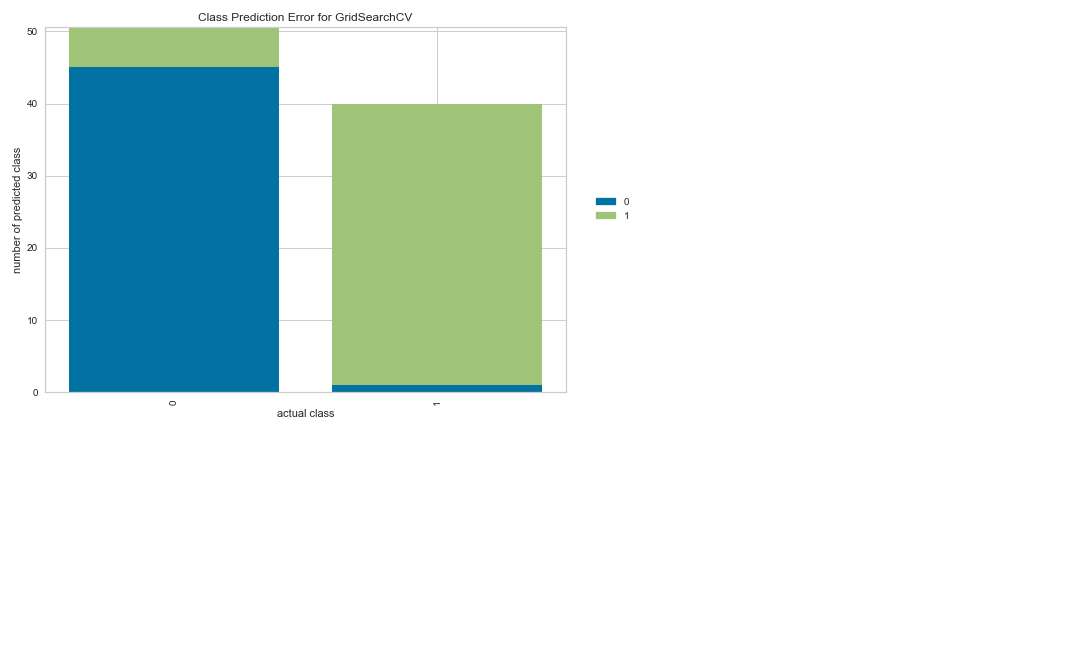

[[36  6]
 [10 39]]


TypeError: classification_report() takes 1 positional argument but 2 were given

In [435]:
from yellowbrick.classifier import ClassPredictionError

visualizer = ClassPredictionError(model)

# Fit the training data to the visualizer
visualizer.fit(X_train_scaled, y_train)

# Evaluate the model on the test data
visualizer.score(X_test_scaled, y_test_pred)

# Draw visualization
visualizer.poof();

print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

In [398]:
## Cross Validation 
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import make_scorer

model = DecisionTreeClassifier(random_state=42)
scores = cross_validate(model, X_train, y_train, scoring = ["accuracy", "precision_micro", "recall_micro", "f1_micro"], cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))

df_scores.mean()[2:]

test_accuracy          0.677
test_precision_micro   0.677
test_recall_micro      0.677
test_f1_micro          0.677
dtype: float64

In [396]:
## Feature importances
model = simple_model
model.feature_importances_
df_fi = pd.DataFrame(index=X.columns, data = model.feature_importances_, 
                      columns = ["Feature Importance"]).sort_values("Feature Importance")

df_fi.sort_values(by="Feature Importance", ascending=False).T

# sns.barplot(data = df_fi, 
#             x = df_fi.index, 
#             y = 'Feature Importance', 
#             order=df_fi.sort_values('Feature Importance', ascending=False).reset_index()['index'])
# plt.xticks(rotation = 90)
# plt.tight_layout()
# plt.show();

,cp,ca,oldpeak,thal,slope,thalach,chol,trestbps,exang,age,sex,restecg,fbs
Feature Importance,0.280,0.200,0.104,0.084,0.071,0.061,0.052,0.045,0.035,0.029,0.023,0.016,0.000


In [385]:
sns.barplot(data = df_fi, 
            x = df_fi.index, 
            y = 'Feature Importance', 
            order=df_fi.sort_values('Feature Importance', ascending=False).reset_index()['index'])
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show();

In [411]:
## Model Evaluate¶

# 1-Logistic Regression

# Model evaluation
model = LogisticRegression(random_state=42)
params = {"penalty" : ["l1", "l2", "elasticnet"],
          "l1_ratio" : np.linspace(0, 1, 50),
          "C" : np.logspace(0, 10, 20)}
gridCV_model = GridSearchCV(model, params, cv=10).fit(X_train_scaled, y_train)

penalty = gridCV_model.best_params_["penalty"] 
C = gridCV_model.best_params_["C"]
l1_ratio = gridCV_model.best_params_["l1_ratio"]

print('Model parameters:\n\npenalty:', penalty,'\nC:', C,'\nl1_ratio:', l1_ratio, '\n\n')

# # Print Scores
model = gridCV_model
classification_report(model)
# train_control_table(model)
# test_control_table(model)


# # Model tunning
# tuned_model = LogisticRegression(penalty = penalty, 
#                                C = C, 
#                                l1_ratio = l1_ratio, 
#                                solver='saga', 
#                                max_iter=5000).fit(X_train_scaled, y_train)
# y_test_pred = tuned_model.predict(X_test_scaled)

Model parameters:

penalty: l2 
C: 37.926901907322495 
l1_ratio: 0.0 


Train:
rmse: 0.37073003424842566
accuracy: 0.8625592417061612
roc_auc_score: 0.9298007246376812
roc_auc_recall_precision_score: 0.9366897066381976 

confusion_matrix:

 [[ 78  18]
 [ 11 104]] 

classification_report:

               precision  recall  f1-score  support
0                 0.876   0.812     0.843   96.000
1                 0.852   0.904     0.878  115.000
accuracy          0.863   0.863     0.863    0.863
macro avg         0.864   0.858     0.860  211.000
weighted avg      0.863   0.863     0.862  211.000 


Test:
rmse: 0.4322189107537832
accuracy: 0.8131868131868132
roc_auc_score: 0.8950437317784257
roc_auc_recall_precision_score: 0.8937609558278151 

confusion_matrix:

 [[34  8]
 [ 9 40]] 

classification_report:

               precision  recall  f1-score  support
0                 0.791   0.810     0.800   42.000
1                 0.833   0.816     0.825   49.000
accuracy          0.813   0.813   

## ROC (Receiver Operating Curve) and AUC (Area Under Curve)

<IPython.core.display.Javascript object>


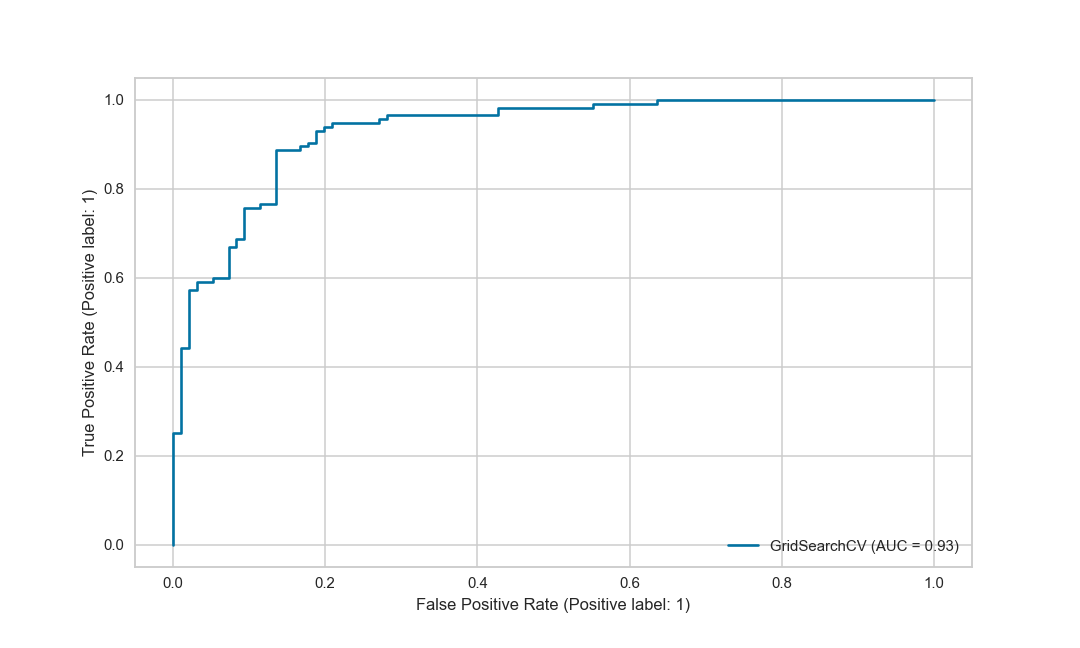

<IPython.core.display.Javascript object>


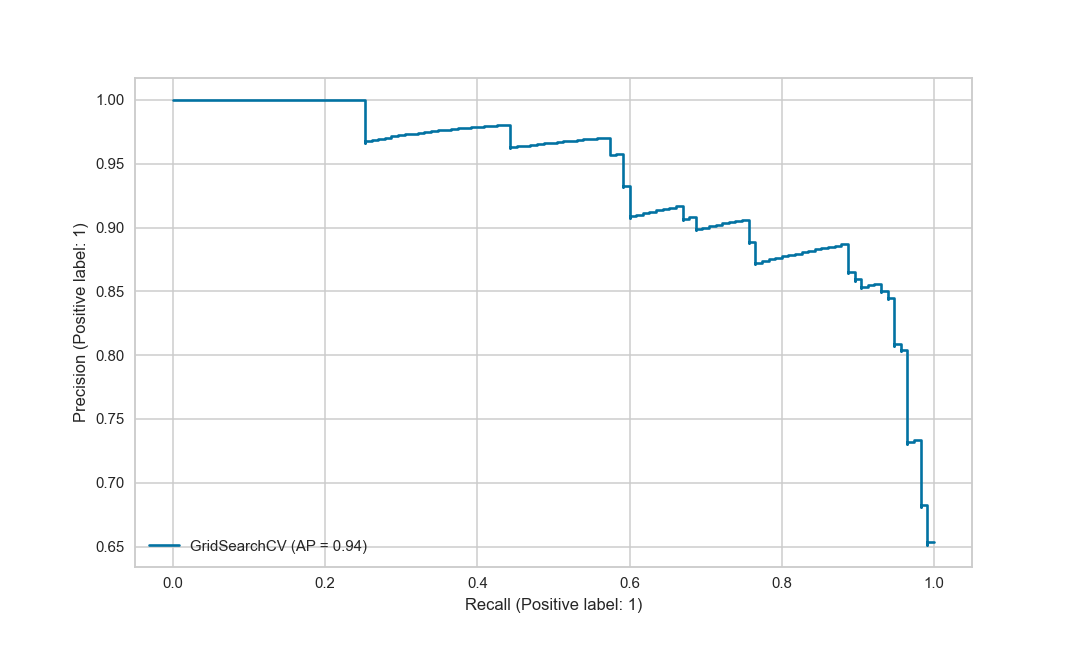

In [426]:
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
model = gridCV_model
plot_roc_curve(model, X_train_scaled, y_train);
plot_precision_recall_curve(model, X_train_scaled, y_train);

<IPython.core.display.Javascript object>


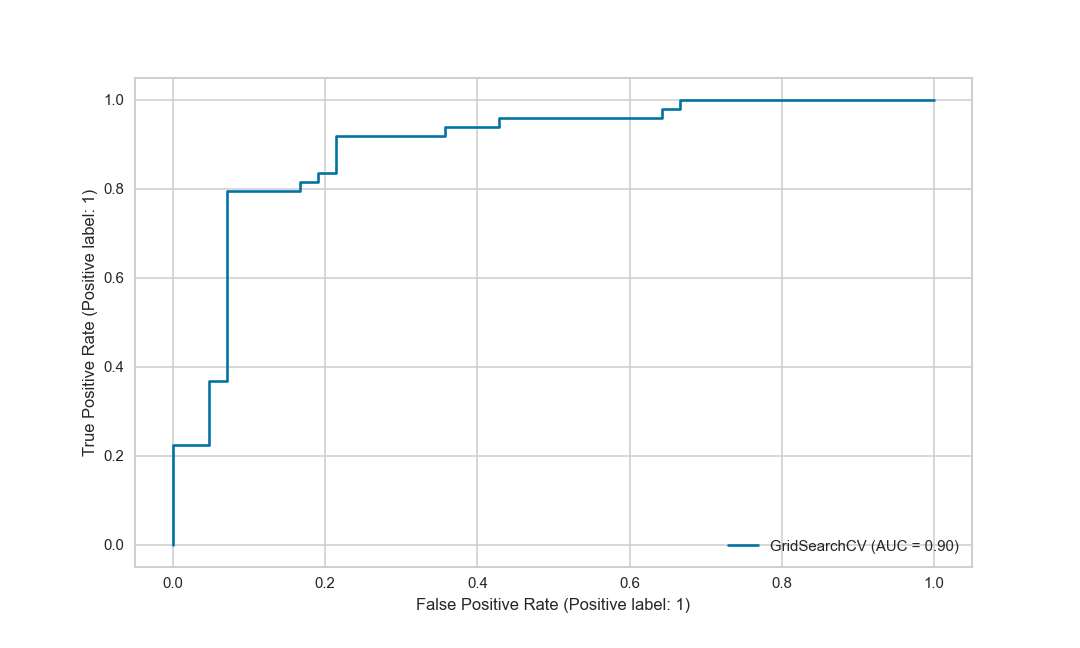

<IPython.core.display.Javascript object>


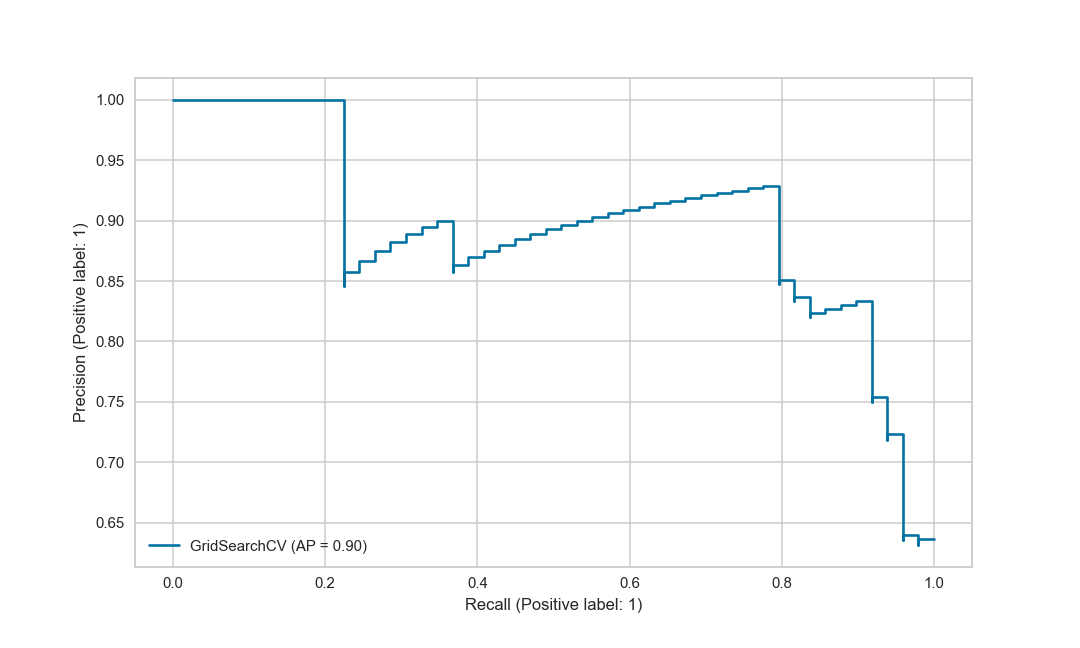

In [420]:
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
model = gridCV_model
plot_roc_curve(model, X_test_scaled, y_test);
plot_precision_recall_curve(model, X_test_scaled, y_test);

## Finding Best Threshold

In [427]:
fp_rate, tp_rate, thresholds = roc_curve(y_test, y_test_pred_proba[:,1])
optimal_idx = np.argmax(tp_rate - fp_rate)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.06618928698447381

In [428]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_pred_proba[:,1])
optimal_idx = np.argmax((2 * precisions * recalls) / (precisions + recalls))  
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.31394764875959474

# Final Model

In [429]:
model = gridCV_model
print("best_score:", model.best_score_, '\n')

best_score: 0.8580086580086579 



# Model Deployment

In [419]:
import pickle
pickle.dump(scaler, open("scaler_stroke", 'wb'))

In [104]:
pickle.dump(final_model, open("final_model_stroke", 'wb'))

In [105]:
my_dict = {"age": [18, 43, 67],
           "hypertension":[0,0,1],
           "heart_disease":[0,1,1],
           "avg_glucose_level": [56.28, 89.17, 127.23],
           "bmi": [18, 25, 29],
           "gender_Male": [1, 1, 0],
           "ever_married_Yes": [0, 1, 1],
           "work_type_Never_worked": [1, 0, 0],
           "work_type_Private": [0, 1, 0],
           "work_type_Self-employed": [0, 0, 1],
           "work_type_children": [1, 0, 0],
           "residence_type_Urban": [1, 0, 0],
           "smoking_status_formerly smoked": [0, 0, 1],
           "smoking_status_never smoked": [1, 0, 0],
           "smoking_status_smoke": [0, 1, 0]
          }

In [106]:
sample = pd.DataFrame(my_dict)
sample

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smoke
0,18,0,0,56.2800000,18,1,0,1,0,0,1,1,0,1,0
1,43,0,1,89.1700000,25,1,1,0,1,0,0,0,0,0,1
2,67,1,1,127.2300000,29,0,1,0,0,1,0,0,1,0,0


In [107]:
scaler_stroke = pickle.load(open("scaler_stroke", "rb"))

In [108]:
sample_scaled = scaler_stroke.transform(sample)
sample_scaled

array([[0.21875   , 0.        , 0.        , 0.005355  , 0.0882016 ,
        1.        , 0.        , 1.        , 0.        , 0.        ,
        1.        , 1.        , 0.        , 1.        , 0.        ],
       [0.52392578, 0.        , 1.        , 0.1571877 , 0.16838488,
        1.        , 1.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ],
       [0.81689453, 1.        , 1.        , 0.33288708, 0.21420389,
        0.        , 1.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ]])

In [109]:
final_model = pickle.load(open("final_model_stroke", "rb"))

In [110]:
predictions = final_model.predict(sample_scaled)
predictions_proba = final_model.predict_proba(sample_scaled)
predictions2 = [1 if i >= optimal_threshold else 0 for i in predictions_proba[:,1]]

In [111]:
sample["pred_proba"] = predictions_proba[:,1]
sample["pred"] = predictions
sample["pred2"] = predictions2
sample

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smoke,pred_proba,pred,pred2
0,18,0,0,56.2800000,18,1,0,1,0,0,1,1,0,1,0,0.0582660,0,0
1,43,0,1,89.1700000,25,1,1,0,1,0,0,0,0,0,1,0.3052126,0,0
2,67,1,1,127.2300000,29,0,1,0,0,1,0,0,1,0,0,0.8119278,1,0


# Implement KNN and Evaluate

In [434]:
## Model Evaluate¶

# 1-KNN Classification

# Model evaluation
model = KNeighborsClassifier()
params = {"n_neighbors": np.arange(1, 50)}
gridCV_model = GridSearchCV(model, params, cv=10).fit(X_train_scaled, y_train)

k_best = gridCV_model.best_params_["n_neighbors"]

print('K:', k_best)

# # Print Scores
model = gridCV_model
classification_report(model)
# train_control_table(model)
# test_control_table(model)


# # Model tunning
# tuned_model = KNeighborsClassifier(n_neighbors = k_best).fit(X_train_scaled, y_train)
# y_test_pred = tuned_model.predict(X_test_scaled)

K: 6
Train:
rmse: 0.36428206351802156
accuracy: 0.8672985781990521
roc_auc_score: 0.9355525362318841
roc_auc_recall_precision_score: 0.9484178509455401 

confusion_matrix:

 [[85 11]
 [17 98]] 

classification_report:

               precision  recall  f1-score  support
0                 0.833   0.885     0.859   96.000
1                 0.899   0.852     0.875  115.000
accuracy          0.867   0.867     0.867    0.867
macro avg         0.866   0.869     0.867  211.000
weighted avg      0.869   0.867     0.868  211.000 


Test:
rmse: 0.4803844614152614
accuracy: 0.7692307692307693
roc_auc_score: 0.8666180758017492
roc_auc_recall_precision_score: 0.8897851359500042 

confusion_matrix:

 [[36  6]
 [15 34]] 

classification_report:

               precision  recall  f1-score  support
0                 0.706   0.857     0.774   42.000
1                 0.850   0.694     0.764   49.000
accuracy          0.769   0.769     0.769    0.769
macro avg         0.778   0.776     0.769   91.000
wei

In [432]:
# KNN Classification
knn_model = KNeighborsClassifier()
knn_params = {"n_neighbors": np.arange(1, 50), "p": [1,2]}
knn_gridCV = GridSearchCV(knn_model, knn_params, cv = 10).\
                      fit(X_train_scaled, y_train)

k_best =knn_gridCV.best_params_["n_neighbors"]

knn_tuned = KNeighborsClassifier(n_neighbors = k_best).fit(X_train_scaled, y_train)
y_test_pred = knn_tuned.predict(X_test_scaled)

print("best_score:", knn_gridCV.best_score_, '\n')
print('K:', k_best)
print('accuracy:', accuracy_score(y_test, y_test_pred))
print('rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)), '\n\n')


best_score: 0.8385281385281385 

K: 9
accuracy: 0.8241758241758241
rmse: 0.4193139346887673 


confusion_matrix:

         0       1
  for knn for knn
0      36       6
1      10      39 


classification_report:

              precision  recall f1-score support
               for knn for knn  for knn for knn
0                0.783   0.857    0.818  42.000
1                0.867   0.796    0.830  49.000
accuracy         0.824   0.824    0.824   0.824
macro avg        0.825   0.827    0.824  91.000
weighted avg     0.828   0.824    0.824  91.000


In [433]:
knn_gridCV.best_params_

{'n_neighbors': 9, 'p': 1}

In [136]:
# KNN Classification
knn_model = KNeighborsClassifier()
knn_params = {"n_neighbors": np.arange(1, 50), "p": [1,2], "weights": ['uniform', "distance"]}
knn_gridCV = GridSearchCV(knn_model, knn_params, cv = 10).\
                      fit(X_train_scaled, y_train)

k_best =knn_gridCV.best_params_["n_neighbors"]

knn_tuned = KNeighborsClassifier(n_neighbors = k_best).fit(X_train_scaled, y_train)
y_test_pred = knn_tuned.predict(X_test_scaled)

print("best_score:", knn_gridCV.best_score_, '\n')
print('K:', k_best)
print('accuracy:', accuracy_score(y_test, y_test_pred))
print('rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)), '\n\n')

knn_conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_test_pred))
knn_conf_matrix.columns = pd.MultiIndex.from_product([knn_conf_matrix.columns, ['for knn']])

knn = get_classification_report(y_test, y_test_pred)
knn.columns = pd.MultiIndex.from_product([knn.columns, ['for knn']])
print('confusion_matrix:\n\n', knn_conf_matrix, '\n\n')
print('classification_report:\n\n', knn)

Best Score:0.8435064935064934
K: 19
Metric: minkowski
Accuracy: 0.7582417582417582
Rmse: 0.4916891718944416 

confusion_matrix: 
 [[33  9]
 [13 36]]

               precision    recall  f1-score   support

           0       0.72      0.79      0.75        42
           1       0.80      0.73      0.77        49

    accuracy                           0.76        91
   macro avg       0.76      0.76      0.76        91
weighted avg       0.76      0.76      0.76        91



### KNN in Pipeline

In [149]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix

operations = [("scaler", StandardScaler()), ("knn_pipe", KNeighborsClassifier())]
knn_pipe_model = Pipeline(steps=operations)
knn_pipe_params = {'knn_pipe__n_neighbors': np.arange(1, 50), "knn_pipe__p": [1,2]}
knn_pipe_gridCV = GridSearchCV(knn_pipe_model, knn_pipe_params, cv=10, scoring= 'f1').fit(X_train, y_train)
k_best = knn_pipe_gridCV.best_params_["knn_pipe__n_neighbors"]

print("Best Score:" + str(knn_pipe_gridCV.best_score_))

knn_pipe_tuned = Pipeline([('scaler',StandardScaler()),('knn_pipe',KNeighborsClassifier(n_neighbors=k_best))]).fit(X, y)
y_test_pred = knn_pipe_tuned.predict(X_test)

print("best_score:", knn_pipe_gridCV.best_score_, '\n')
print('K:', k_best)
print('accuracy:', accuracy_score(y_test, y_test_pred))
print('rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)), '\n\n')

knn_pipe_conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_test_pred))
knn_pipe_conf_matrix.columns = pd.MultiIndex.from_product([knn_pipe_conf_matrix.columns, ['for knn_pipe']])

knn_pipe = get_classification_report(y_test, y_test_pred)
knn_pipe.columns = pd.MultiIndex.from_product([knn_pipe.columns, ['for knn_pipe']])
print('confusion_matrix:\n\n', knn_pipe_conf_matrix, '\n\n')
print('classification_report:\n\n', knn_pipe)

# knn_pipe_model.get_params()
# knn_pipe_model.set_params(knn_pipe__n_neighbors= 9) #Euclidean
# knn_pipe_model.get_params()
# knn_pipe_model["scaler"]
# knn_pipe_model["knn_pipe"]

Best Score:0.8637867037177382
K: 45
Accuracy: 0.8241758241758241
Rmse: 0.4193139346887673 

confusion_matrix: 
 [[31 11]
 [ 5 44]]

               precision    recall  f1-score   support

           0       0.86      0.74      0.79        42
           1       0.80      0.90      0.85        49

    accuracy                           0.82        91
   macro avg       0.83      0.82      0.82        91
weighted avg       0.83      0.82      0.82        91



### KNN Pipeline Final

In [187]:
# knn_pipe_tuned.get_params()

In [152]:
knn_pipe_final = Pipeline([('scaler',StandardScaler()),('knn',KNeighborsClassifier(n_neighbors=k_best))]).fit(X, y)

In [188]:
# knn_pipe_final.get_params()

In [186]:
samples = df.sample(5)
X_samples = samples.drop(target, axis=1)
y_samples = samples[target]

predictions = knn_pipe_final.predict(X_samples)
predictions_proba = knn_pipe_final.predict_proba(X_samples)

samples["pred"] = predictions
samples["pred_proba"] = predictions_proba[:,1]
samples

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,pred,pred_proba
66,51,1,2,100,222,0,1,143,1,1.200,1,0,2,1,1,0.689
230,47,1,2,108,243,0,1,152,0,0.000,2,0,2,0,1,0.889
136,60,0,2,120,178,1,1,96,0,0.000,2,0,2,1,1,0.844
38,65,0,2,155,269,0,1,148,0,0.800,2,0,2,1,1,0.867
185,44,1,0,112,290,0,0,153,0,0.000,2,1,2,0,1,0.689


## Implement SVM and Evaluate

In [177]:
# SVM Classification
from sklearn.model_selection import GridSearchCV
svm_model = SVC()
svm_params = {'C': [0.1,1, 10, 100, 1000],
              'gamma': ["scale", "auto", 1,0.1,0.01,0.001,0.0001],
              'kernel': ['rbf', 'linear']}

svm_gridCV = GridSearchCV(svm_model, svm_params, verbose=3, refit=True).\
                    fit(X_train_scaled, y_train)

C, gamma, kernel = svm_gridCV.best_params_["C"], svm_gridCV.best_params_["gamma"], svm_gridCV.best_params_["kernel"]

svm_tuned = SVC(C = C, gamma = gamma, kernel = kernel).fit(X_train_scaled, y_train)

y_test_pred = svm_tuned.predict(X_test_scaled)


print("best_score:", svm_gridCV.best_score_, '\n')
print('C:', C, 'gamma:', gamma, 'kernel:', kernel)
print('accuracy:', accuracy_score(y_test, y_test_pred))
print('rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)), '\n\n')

svm_conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_test_pred))
svm_conf_matrix.columns = pd.MultiIndex.from_product([svm_conf_matrix.columns, ['for svm']])

svm = get_classification_report(y_test, y_test_pred)
svm.columns = pd.MultiIndex.from_product([svm.columns, ['for svm']])
print('confusion_matrix:\n\n', svm_conf_matrix, '\n\n')
print('classification_report:\n\n', svm)

Fitting 5 folds for each of 70 candidates, totalling 350 fits
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.837 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.786 total time=   0.0s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.714 total time=   0.0s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.881 total time=   0.0s
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.667 total time=   0.0s
[CV 1/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.837 total time=   0.0s
[CV 2/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.786 total time=   0.0s
[CV 3/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.714 total time=   0.0s
[CV 4/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.857 total time=   0.0s
[CV 5/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.738 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=auto, kernel=rbf;, score=0.535 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=auto, kernel=rbf

[CV 3/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.714 total time=   0.0s
[CV 4/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.762 total time=   0.0s
[CV 5/5] END .......C=1, gamma=0.01, kernel=rbf;, score=0.667 total time=   0.0s
[CV 1/5] END ....C=1, gamma=0.01, kernel=linear;, score=0.884 total time=   0.0s
[CV 2/5] END ....C=1, gamma=0.01, kernel=linear;, score=0.786 total time=   0.0s
[CV 3/5] END ....C=1, gamma=0.01, kernel=linear;, score=0.786 total time=   0.0s
[CV 4/5] END ....C=1, gamma=0.01, kernel=linear;, score=0.905 total time=   0.0s
[CV 5/5] END ....C=1, gamma=0.01, kernel=linear;, score=0.738 total time=   0.0s
[CV 1/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.535 total time=   0.0s
[CV 2/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.548 total time=   0.0s
[CV 3/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.548 total time=   0.0s
[CV 4/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.548 total time=   0.0s
[CV 5/5] END ......C=1, gamm

[CV 3/5] END .C=100, gamma=scale, kernel=linear;, score=0.857 total time=   0.0s
[CV 4/5] END .C=100, gamma=scale, kernel=linear;, score=0.905 total time=   0.0s
[CV 5/5] END .C=100, gamma=scale, kernel=linear;, score=0.762 total time=   0.0s
[CV 1/5] END .....C=100, gamma=auto, kernel=rbf;, score=0.837 total time=   0.0s
[CV 2/5] END .....C=100, gamma=auto, kernel=rbf;, score=0.810 total time=   0.0s
[CV 3/5] END .....C=100, gamma=auto, kernel=rbf;, score=0.881 total time=   0.0s
[CV 4/5] END .....C=100, gamma=auto, kernel=rbf;, score=0.857 total time=   0.0s
[CV 5/5] END .....C=100, gamma=auto, kernel=rbf;, score=0.810 total time=   0.0s
[CV 1/5] END ..C=100, gamma=auto, kernel=linear;, score=0.884 total time=   0.0s
[CV 2/5] END ..C=100, gamma=auto, kernel=linear;, score=0.833 total time=   0.0s
[CV 3/5] END ..C=100, gamma=auto, kernel=linear;, score=0.857 total time=   0.0s
[CV 4/5] END ..C=100, gamma=auto, kernel=linear;, score=0.905 total time=   0.0s
[CV 5/5] END ..C=100, gamma=

[CV 5/5] END ..C=1000, gamma=0.1, kernel=linear;, score=0.762 total time=   0.1s
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.884 total time=   0.0s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.857 total time=   0.0s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.857 total time=   0.0s
[CV 4/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.881 total time=   0.0s
[CV 5/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.786 total time=   0.0s
[CV 1/5] END .C=1000, gamma=0.01, kernel=linear;, score=0.884 total time=   0.0s
[CV 2/5] END .C=1000, gamma=0.01, kernel=linear;, score=0.833 total time=   0.1s
[CV 3/5] END .C=1000, gamma=0.01, kernel=linear;, score=0.857 total time=   0.1s
[CV 4/5] END .C=1000, gamma=0.01, kernel=linear;, score=0.905 total time=   0.0s
[CV 5/5] END .C=1000, gamma=0.01, kernel=linear;, score=0.762 total time=   0.2s
[CV 1/5] END ...C=1000, gamma=0.001, kernel=rbf;, score=0.907 total time=   0.0s
[CV 2/5] END ...C=1000, gamm

In [179]:
print("Best Score:" + str(svm_gridCV.best_score_))
print('C:', C, 'gamma:', gamma, 'kernel:', kernel)
print('Accuracy:', accuracy_score(y_test, y_test_pred))
#print('Accuracy:',knn_tuned.score(X_test, y_test))
print('Rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)), '\n')
print('confusion_matrix: \n', confusion_matrix(y_test, y_test_pred))
print('\n',classification_report(y_test, y_test_pred))

Best Score:0.8575858250276855
C: 10 gamma: scale kernel: linear
Accuracy: 0.8351648351648352
Rmse: 0.40599897147057507 

confusion_matrix: 
 [[35  7]
 [ 8 41]]

               precision    recall  f1-score   support

           0       0.81      0.83      0.82        42
           1       0.85      0.84      0.85        49

    accuracy                           0.84        91
   macro avg       0.83      0.84      0.83        91
weighted avg       0.84      0.84      0.84        91



## Implement CART and Evaluate

In [ ]:
# ## Modelling - Decision Tree Classifier

# # Simple Classifier
# from sklearn.tree import DecisionTreeClassifier
# DT_model = DecisionTreeClassifier(random_state=42)
# DT_model.fit(X_train, y_train)
# y_test_pred = DT_model.predict(X_test)
# from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix
# confusion_matrix(y_test, y_test_pred)
# plot_confusion_matrix(DT_model,X_test,y_test_pred)

# from yellowbrick.classifier import ClassPredictionError

# visualizer = ClassPredictionError(DT_model)

# # Fit the training data to the visualizer
# visualizer.fit(X_train, y_train)

# # Evaluate the model on the test data
# visualizer.score(X_test, y_test_pred)

# # Draw visualization
# visualizer.poof();

# print(confusion_matrix(y_test, y_test_pred))
# print(classification_report(y_test, y_test_pred))



# ## Cross Validation 
# from sklearn.model_selection import cross_val_score, cross_validate
# from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
# from sklearn.metrics import make_scorer

# model = DecisionTreeClassifier(max_depth=None, random_state=42)

# scores = cross_validate(model, X_train, y_train, scoring = ["accuracy", "precision_macro", "recall_macro", "f1_macro"], cv = 10)
# df_scores = pd.DataFrame(scores, index = range(1, 11))
# df_scores

# df_scores.mean()[2:]



# ## Feature importances
# DT_model.feature_importances_
# df_f_i = pd.DataFrame(index=X.columns, data = DT_model.feature_importances_, 
#                       columns = ["Feature Importance"]).sort_values("Feature Importance")
# df_f_i

# sns.barplot(x = df_f_i.index, y = 'Feature Importance', data = df_f_i)
# plt.xticks(rotation = 90)
# plt.tight_layout()

# X2 = X.drop(columns = ["flipper_length_mm"])
# # The feature that weighs too much on the estimate can sometimes cause overfitting. 
# # For this reason, the most important feature can be dropped and the scores can be checked again

# X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.3, random_state=42)
# DT2_model = DecisionTreeClassifier(random_state=42)

# DT2_model.fit(X_train2, y_train2) 
# y_test_pred2 = DT2_model.predict(X_test2)
# print(confusion_matrix(y_test2, y_test_pred2))
# print(classification_report(y_test2, y_test_pred2))

# ## Cros validation
# model = DecisionTreeClassifier(random_state=42)

# scores = cross_validate(model, X_train2, y_train2, scoring = ["accuracy", "precision_macro", "recall_macro", "f1_macro"], cv = 10)
# df_scores = pd.DataFrame(scores, index = range(1, 11))
# df_scores

# df_scores.mean()[2:]


# ## Scoring
# from sklearn.metrics import make_scorer
# scoring = {'precision-Adelie': make_scorer(precision_score,  average='weighted', pos_label="Adelie"),
#            'recall-Adelie': make_scorer(recall_score, average='weighted', pos_label ="Adelie"),
#            'f1-Adelie': make_scorer(f1_score, average='weighted', pos_label = "Adelie"),
          
#           'precision-Chinstrap': make_scorer(precision_score,  average='weighted', pos_label="Chinstrap"),
#           'recall-Chinstrap': make_scorer(recall_score, average='weighted', pos_label ="Chinstrap"),
#           'f1-Chinstrap': make_scorer(f1_score, average='weighted', pos_label = "Chinstrap"),
          
          
#           'precision-Gentoo': make_scorer(precision_score,  average='weighted', pos_label="Gentoo"),
#           'recall-Gentoo': make_scorer(recall_score, average='weighted', pos_label ="Gentoo"),
#           'f1-Gentoo': make_scorer(f1_score, average='weighted', pos_label = "Gentoo"),
          
#           }
# for i, j in scoring.items():
#     model = DecisionTreeClassifier(random_state=42)
#     scores = cross_val_score(model, X_train2, y_train2, cv = 10, scoring = j, n_jobs = -1)
#     #print([round(i, 4) for i in scores], "\n")
#     print(f" {i:20} : %{scores.mean()*100:.2f}, std : %{scores.std()*100:.3f} \n")

In [ ]:
## Understanding Hyperparameters

### Max Depth
pruned_tree = DecisionTreeClassifier(max_depth=5, random_state=42)
pruned_tree.fit(X_train,y_train)
model_name = pruned_tree
report_model(model_name)
plt.figure(figsize=(12,8),dpi=150)
plot_tree(model_name, filled=True, feature_names=X.columns, class_names=df.species.unique());

## Max Leaf Nodes
pruned_tree_2 = DecisionTreeClassifier(max_leaf_nodes=7, random_state=42)
pruned_tree_2.fit(X_train,y_train)
model_name = pruned_tree2
report_model(model_name)
plt.figure(figsize=(12,8),dpi=150)
plot_tree(model_name, filled=True, feature_names=X.columns, class_names=df.species.unique());

## Entropy Tree
entropy_tree = DecisionTreeClassifier(criterion='entropy', random_state=42,)
entropy_tree.fit(X_train,y_train)
model_name = entropy_tree
report_model(model_name)
plt.figure(figsize=(12,8),dpi=150)
plot_tree(model_name, filled=True, feature_names=X.columns, class_names=df.species.unique());

## Max_features, Splitter
tree = DecisionTreeClassifier(splitter = "best", max_features=3)
tree.fit(X_train,y_train)
model_name = tree
report_model(model_name)
plt.figure(figsize=(12,8),dpi=150)
plot_tree(model_name, filled=True, feature_names=X.columns, class_names=df.species.unique());

## Find Best Parameters

from sklearn.model_selection import GridSearchCV
cart_gridCV = DecisionTreeClassifier(random_state=42)
cart_params = {"splitter":["best", "random"],
              "max_features":[None, "auto", "log2", 2, 3,4, 5,6, 7],
              "max_depth": [None, 2,3, 4, 5],
              "min_samples_leaf": [1, 2, 3, 4, 5, 6,7],
              "min_samples_split": [2, 3, 5, 6, 7,8,9]}
cart_tuned = GridSearchCV(cart_gridCV,
                          cart_params,
                          scoring='f1_macro',
                          cv=10,
                          n_jobs = -1).fit(X_train, y_train)
model_name = cart_tuned
report_model(model_name)
plt.figure(figsize=(12,8),dpi=150)
plot_tree(model_name, filled=True, feature_names=X.columns, class_names=df.species.unique());

In [208]:
# CART Classification
cart_model = DecisionTreeClassifier()
cart_params = {"max_depth": range(1,10), "min_samples_split" : list(range(2,50))}

cart_gridCV = GridSearchCV(cart_model, cart_params, cv = 10, n_jobs = -1, verbose = 2).fit(X_train_scaled, y_train)

max_depth, min_samples_split = cart_gridCV.best_params_["max_depth"], cart_gridCV.best_params_["min_samples_split"]

cart_tuned = DecisionTreeClassifier(max_depth = max_depth, 
                                   min_samples_split = min_samples_split).fit(X_train_scaled, y_train)

y_test_pred = cart_tuned.predict(X_test_scaled)

print("best_score:", cart_gridCV.best_score_, '\n')
print('max_depth:', max_depth, 'min_samples_split:', min_samples_split)
print('accuracy:', accuracy_score(y_test, y_test_pred))
print('rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)), '\n\n')

cart_conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_test_pred))
cart_conf_matrix.columns = pd.MultiIndex.from_product([cart_conf_matrix.columns, ['for cart']])

cart = get_classification_report(y_test, y_test_pred)
cart.columns = pd.MultiIndex.from_product([cart.columns, ['for cart']])
print('confusion_matrix:\n\n', cart_conf_matrix, '\n\n')
print('classification_report:\n\n', cart)

Fitting 10 folds for each of 432 candidates, totalling 4320 fits
Best Score: 0.7439393939393939


## Implement RandomForest and Evaluate

In [166]:
# RandomForest Classification
rf_model = RandomForestClassifier(random_state = 42).fit(X_train_scaled, y_train)

rf_params = {"max_depth": [2,5,8,10],
             "max_features": [2,5,8],
             "n_estimators": [10,500,1000],
             "min_samples_split": [2,5,10]}

rf_gridCV = GridSearchCV(rf_model, 
                         rf_params, 
                         cv = 10, 
                         n_jobs = -1, 
                         verbose = 2).fit(X_train_scaled, y_train)

print("Best Score:" + str(rf_gridCV.best_score_))

max_depth, max_features, min_samples_split, n_estimators = rf_gridCV.best_params_["max_depth"], rf_gridCV.best_params_["max_features"], rf_gridCV.best_params_["min_samples_split"], rf_gridCV.best_params_["n_estimators"]

rf_tuned = RandomForestClassifier(max_depth = max_depth, 
                                  max_features = max_features, 
                                  min_samples_split = min_samples_split,
                                  n_estimators = n_estimators).fit(X_train_scaled, y_train)
y_test_pred = rf_tuned.predict(X_test_scaled)

y_test_pred = rf_tuned.predict(X_test_scaled)

print("best_score:", rf_gridCV.best_score_, '\n')
print('max_depth:', max_depth, 'min_samples_split:', min_samples_split, 'n_estimators:', n_estimators)
print('accuracy:', accuracy_score(y_test, y_test_pred))
print('rmse:', np.sqrt(mean_squared_error(y_test, y_test_pred)), '\n\n')

rf_conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_test_pred))
rf_conf_matrix.columns = pd.MultiIndex.from_product([rf_conf_matrix.columns, ['for rf']])

rf = get_classification_report(y_test, y_test_pred)
rf.columns = pd.MultiIndex.from_product([rf.columns, ['for rf']])
print('confusion_matrix:\n\n', rf_conf_matrix, '\n\n')
print('classification_report:\n\n', rf)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Best Score:0.8292207792207792
Accuracy: 0.8461538461538461


# Data Preprocessing

# Visually compare models based on your chosen metric

# Chose best model and make a random prediction

In [ ]:
df.Cancer.value_counts()
sns.countplot(df["Cancer"])
sns.scatterplot(x = 'mean area', y = 'mean smoothness', hue = 'Cancer', data = df)

df.corr()['Compressive Strength (28-day)(Mpa)'].drop('Compressive Strength (28-day)(Mpa)').sort_values().plot.barh()
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(),annot=True, cmap='viridis')



In [ ]:
compare = pd.DataFrame({"Model": ["Logistic Regression", "KNN", "SVM", "SVM Tuned", "DT", "DT Tuned", "RF", "RF Tuned"],
                        "Accuracy": [log_acc, knn_acc, svm_acc, svm_tuned_acc, dt_acc, dt_tuned_acc, rf_acc, rf_tuned_acc],
                        "Recall": [log_recall, knn_recall, svm_recall,  svm_tuned_recall, dt_recall, dt_tuned_recall, rf_recall, rf_tuned_recall]})

def labels(ax):
    for p in ax.patches:
        width = p.get_width()                        # get bar length
        ax.text(width,                               # set the text at 1 unit right of the bar
                p.get_y() + p.get_height() / 2,      # get Y coordinate + X coordinate / 2
                '{:1.2f}'.format(width),             # set variable to display, 2 decimals
                ha = 'left',                         # horizontal alignment
                va = 'center')                       # vertical alignment
    
plt.figure(figsize=(14,10))
plt.subplot(211)
compare = compare.sort_values(by="Accuracy", ascending=False)
ax=sns.barplot(x="Accuracy", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.subplot(212)
compare = compare.sort_values(by="Recall", ascending=False)
ax=sns.barplot(x="Recall", y="Model", data=compare, palette="Blues_d")
labels(ax)
plt.show()